
# Sistema de clasificación de tipos de cáncer cerebral mediante redes neuronales

Desarrollar un método basado en redes neuronales convolucionales que permita
clasificar con exactitud imágenes extraídas de MRIs en una de las 4 categorías

- Glioma: Detecta masas anómalas con bordes irregulares y heterogeneidad en el tejido cerebral.
- Meningioma: Identifica tumores bien delimitados originados en las meninges.
- Pituitary: Clasifica adenomas hipofisarios en la región selar.
- Tejido sano: Diferencia el tejido cerebral normal sin anomalías presentes


In [1]:
pip install kagglehub


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchsummary


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importar librerias
import random
import kagglehub
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import copy

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import pandas as pd


from collections import Counter

from torchvision import models
from torchsummary import summary

In [4]:
# Descargar el enlace del Dataset
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

100%|██████████| 236M/236M [00:01<00:00, 159MB/s]  

Extracting model files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [5]:
# Verificar que se esté trabajando con GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


### 1. Preprocesamiento de imagenes

### 1.1 Parámetros para el preprocesado

In [6]:
# Folder del dataset
dataset_path = '/root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1'

# Tamaño de las imágenes
img_size = 180

# Tamaño de batch
batch_size = 32

# Porcentaje de datos para validación
val_split = 0.2

# Semilla
seed = 42
torch.manual_seed(seed)

### 1.2 Pipeline de preprocesamiento

A continuacion se screa el pipeline de preprocesamiento de images, el cual realiza los siguientes pasos:
* redimensiona la imagen a 180x180
* se Convierte la imagen para que tenga un solo canal en escala de grices.
* se aplica normalizacion a los datos para que queden en el rando de [-1, 1]
------
Para el conjunto de datos de entrenamiento, se decide aplicar, además de los pasos previos, técnicas de aumento de datos (data augmentation) para enriquecer la variedad de ejemplos y mejorar la generalización del modelo.
* se  refleja la imagen de izquierda a derecha.
* se rota la imagen de manera aleatoria entre -15 y 15 grados.
* se ajusta aleatoriamente el brillo y el contraste de la imagen dentro de un rango de 0.2

In [7]:
# Pipeline de preparación de imágenes (Proprocesamiento)

# Transformaciones para el conjunto de entrenamiento con data augmentation
train_transform = transforms.Compose([
    # Redimensiona la imagen para que todas tengan un tamaño fijo
    transforms.Resize((img_size, img_size)),
    # Convierte las imágenes a escalas de grises para tener 1 solo canal 
    transforms.Grayscale(num_output_channels=1),

    ###### inicio data augmentation en train #######
    # Reflejar de forma horizontal la imagen
    transforms.RandomHorizontalFlip(),
    # Rotaciones aleatorias de la imágen entre -15 y 15 grados
    transforms.RandomRotation(degrees=15),
    # Desplaza horizontal y verticalmente las imágenes
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    # Variación de brillo y contraste, simula variaciones en el brillo y contraste
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ###### fin data augmentation en train #######

    # Convierte imágenes en tensores de [0,255] a [0,1]
    transforms.ToTensor(),
    # Centrar alrededor de 0 con un rango aproximado de [-1,1]
    transforms.Normalize([0.5], [0.5])
])

# Transformaciones para el conjunto de validación
val_transform = transforms.Compose([
    # Redimensiona la imagen para que todas tengan un tamaño fijo
    transforms.Resize((img_size, img_size)),
    # Convierte las imágenes a escalas de grises para tener 1 solo canal y no 3 duplicados
    transforms.Grayscale(num_output_channels=1),
    # Convierte imágenes en tensores de [0,255] a [0,1]
    transforms.ToTensor(),
    # Centrar alrededor de 0 con un rango aproximado de [-1,1]
    transforms.Normalize([0.5], [0.5])
])

### 2. Division del dataset

El dataset se divide en datos de train y val. Adicional, se aplica el pipeline de preprocesado.

In [8]:
# Cargar el dataset con ImageFolder dado que la estructura provienen de directorios 

dataset = datasets.ImageFolder(root=dataset_path)

# Obtener las etiquetas de las imágenes
labels = [item[1] for item in dataset.samples]  

# Dividimos el dataset de manera estratificada
Stratified = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=seed)

for train_index, val_index in Stratified.split(np.zeros(len(labels)), labels):
    pass  # Solo necesitamos una división

# Con transform aplicar el pipeline de preprocesado espeficado en la celda anterior para cada dataset
train_dataset = ImageFolder(root=dataset_path, transform=train_transform)
val_dataset = ImageFolder(root=dataset_path, transform=val_transform)

# Seleccionamos los indices adecuado de cada dataset transformado
train_db = torch.utils.data.Subset(train_dataset, train_index)
val_db = torch.utils.data.Subset(val_dataset, val_index)

# Cargamos los datos por baches
train_data_load = DataLoader(train_db, batch_size=batch_size, shuffle=True)
val_data_load = DataLoader(val_db, batch_size=batch_size, shuffle=False)

Se obtiene la ditribuccion de las clases para el dataset completo y tambien para las divisiones previas que se realizaron.


Dataset completo
Etiqueta: glioma, Cantidad de imágenes: 1621
Etiqueta: healthy, Cantidad de imágenes: 2000
Etiqueta: meningioma, Cantidad de imágenes: 1645
Etiqueta: pituitary, Cantidad de imágenes: 1757


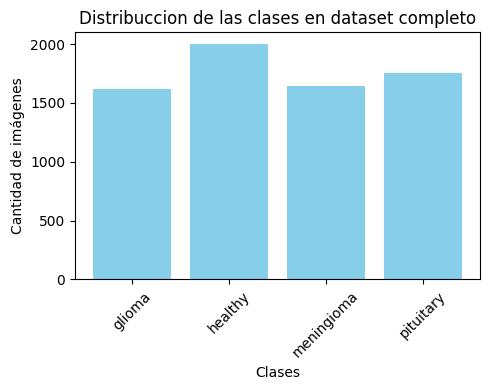


Dataset de Entrenamiento
Etiqueta: healthy, Cantidad de imágenes: 1600
Etiqueta: pituitary, Cantidad de imágenes: 1405
Etiqueta: meningioma, Cantidad de imágenes: 1316
Etiqueta: glioma, Cantidad de imágenes: 1297

Dataset de Validación
Etiqueta: healthy, Cantidad de imágenes: 400
Etiqueta: glioma, Cantidad de imágenes: 324
Etiqueta: pituitary, Cantidad de imágenes: 352
Etiqueta: meningioma, Cantidad de imágenes: 329


In [9]:
# Imprimir la cantidad de imágenes por cada categoría (Clase)
class_counts = Counter(labels)
print("\nDataset completo")
for class_idx, count in class_counts.items():
    # Obtener el nombre de la clase a partir del índice
    class_name = dataset.classes[class_idx]  
    print(f"Etiqueta: {class_name}, Cantidad de imágenes: {count}")
    
plt.figure(figsize=(5, 4))
plt.bar([dataset.classes[class_idx] for class_idx in class_counts.keys()], list(class_counts.values()), color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Cantidad de imágenes')
plt.title('Distribuccion de las clases en dataset completo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    
# Para el dataset de entrenamiento
train_labels = [dataset.samples[i][1] for i in train_db.indices]
train_class_counts = Counter(train_labels)

# Para el dataset de validación
val_labels = [dataset.samples[i][1] for i in val_db.indices]
val_class_counts = Counter(val_labels)

# Imprimir resultados del set de entrenamiento
print("\nDataset de Entrenamiento")
for class_idx, count in train_class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Etiqueta: {class_name}, Cantidad de imágenes: {count}")

# Imprimir resultados del set de validación
print("\nDataset de Validación")
for class_idx, count in val_class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Etiqueta: {class_name}, Cantidad de imágenes: {count}")

### 3. Visualizacion de los datos
Se realiza la visualizacion de algunas imagenes para referencia

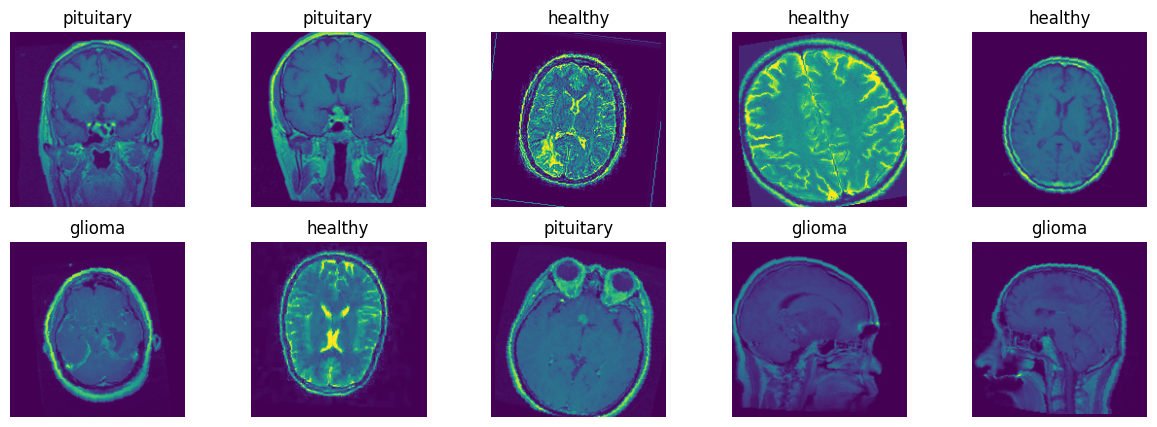

In [10]:
# Función para mostrar imágenes
def show_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    axes = axes.flatten()

    for i in range(10):
        img = images[i].permute(1, 2, 0)  
        img = img * 0.5 + 0.5  
        axes[i].imshow(img.numpy())
        axes[i].set_title(dataset.classes[labels[i]])
        axes[i].axis('off')
    plt.show()

# Visualizar
show_images(train_data_load)

### 4. Funcion de entrenamiento ( train)

* Coloca el modelo en modo entrenamiento (model.train()).
* Recorre los minibatches del conjunto de entrenamiento.

Para cada batch:

* Reinicia los gradientes del optimizador.
* Realiza una pasada hacia adelante.
* Calcula la pérdida.
* Realiza retropropagación.
* Actualiza los pesos del modelo
* Acumula la pérdida total y el número de predicciones correctas.

In [35]:
# Función de entrenamiento

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

### 5. Funcion de evaluacion (evaluate)

* Pone el modelo en modo evaluación (model.eval())
* Desactiva el cálculo de gradientes para acelerar el proceso

Recorre los batches del conjunto de validación y:

* Obtiene las predicciones y calcula la pérdida.
* Acumula la pérdida total y la cantidad de predicciones correctas.
* Devuelve la pérdida promedio y la precisión en validación.

In [36]:
# Función de evaluación

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

### 7. Etapa de modelado

Para abordar el caso planteado, se decide probar 3 soluciones, dos de ella con arquitecturas propuestas en investigaciones relacionadas y la última a partir de transfer learning con EfficientNetB0 de la familia de EfficientNet de Google:

### Arquitectura # 1 Red Neuronal Convolicional (CNN) 

Esta CNN cuenta con tres bloques:

Bloque 1: Busca extraer características simples (Bordes, contornos y patrones simples):


* Capa 1: 4 filtros, kernel 3x3 y padding=1.
* Capa 2: 8 filtros, kernel 3x3 y padding=1.
* Batch Normalization después de cada convolución.
* Maxpool: 2x2, reduce resolución a la mitad


Bloque 2: Busca extraer características como texturas y formas más complejas:

* Capa 1: 16 filtros, kernel 5x5 y padding=2.
* Capa 2: 32 filtros, kernel 5x5 y padding=2.
* Capa 2: 64 filtros, kernel 5x5 y padding=2.
* Batch Normalization después de cada convolución.
* Maxpool: 2x2, reduce resolución a la mitad

Bloque 3: Busca extraer características más profundas:

* Capa 1: 128 filtros, kernel 5x5 y padding=2.
* Capa 2: 256 filtros, kernel 5x5 y padding=2.
* Batch Normalization después de cada convolución.
* AdaptiveAvgPool: Ayuda a garantizar una salida fija, necesaria para la capa densa.

Bloque 4: Bloque de clasificación (4 clases):

* Flatten del tensor (1024)
* Capa densa: Predicción de clases.

In [11]:
class TumorMRICNN(nn.Module):
    def __init__(self, num_classes=4):
        super(TumorMRICNN, self).__init__()

        # Estás capas iniciales buscan identificar características mas simples como bordes, contornos o lineas
        # Capa convolicional 1 con entrada (1 canal) , con 4 filtros, kernel 3x3 con stride de 1 y padding para no perder los bordes
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)  
        self.bn1 = nn.BatchNorm2d(4)

        # Capa convolicional 2 con 8 filtros, kernel 3x3 con stride de 1 y padding para no perder los bordes
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)

        # Max Pooling de 2x2 con un stride de 2 que reduce la imagen a la mitad conservando la representación
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        # Estás capas con mayor cantidad de filtros pretenden identificar carácterísticas mas complejas como los tumores
        # Capa convolicional 3 con 16 filtros, kernel 5x5 con stride de 1 y padding de 2 dado que el kernel es 5x5 para no perder los bordes
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(16)

        # Capa convolicional 4 con 32 filtros, kernel 5x5 con stride de 1 y padding de 2 dado que el kernel es 5x5 para no perder los bordes
        self.conv4 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(32)

        # Capa convolicional 5 con 64 filtros, kernel 5x5 con stride de 1 y padding de 2 dado que el kernel es 5x5 para no perder los bordes
        self.conv5 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn5 = nn.BatchNorm2d(64)

        # Max Pooling con un stride de 2 que reduce la imagen a la mitad conservando la representación
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  

        # Capa convolicional 6 con 128 filtros, kernel 7x7 con stride de 1 y padding de 3 dado que el kernel es 7x7 ((7-1/2)) para no perder los bordes
        self.conv6 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3)
        self.bn6 = nn.BatchNorm2d(128)

        # Capa convolicional 7 con 256 filtros, kernel 3x3 con stride de 1 y padding de 1 dado que el kernel es 3x3 para no perder los bordes
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)

        # Max Pooling final, este es adaptativo y fuerza la salida a 2x2 dado que la la capa completamente conectada requiere que este tamaño sea fijo
        self.pool3 = nn.AdaptiveAvgPool2d((2, 2))  

        # Fully connected layer
        self.fc = nn.Linear(256 * 2 * 2, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)

        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Definicion de optimizador y funcion de perdida
se implementa el optimizador Adam con una tasa de aprendizaje del 0.001 y funcion de perdida CrossEntropyLoss

In [12]:
# Instanciar modelo
model_1 = TumorMRICNN(num_classes=4).to(device)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

print(model_1)

TumorMRICNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [15]:
summary(model_1, input_size=(1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 180, 180]              40
       BatchNorm2d-2          [-1, 4, 180, 180]               8
            Conv2d-3          [-1, 8, 180, 180]             296
       BatchNorm2d-4          [-1, 8, 180, 180]              16
         MaxPool2d-5            [-1, 8, 90, 90]               0
            Conv2d-6           [-1, 16, 90, 90]           3,216
       BatchNorm2d-7           [-1, 16, 90, 90]              32
            Conv2d-8           [-1, 32, 90, 90]          12,832
       BatchNorm2d-9           [-1, 32, 90, 90]              64
           Conv2d-10           [-1, 64, 90, 90]          51,264
      BatchNorm2d-11           [-1, 64, 90, 90]             128
        MaxPool2d-12           [-1, 64, 45, 45]               0
           Conv2d-13          [-1, 128, 45, 45]         401,536
      BatchNorm2d-14          [-1, 128,

### Entrenamiento y evaluación del modelo

Se aplican las funciones de entrenamiento y evaluación en un bucle durante 150 épocas con una parada temprana de 20, observando el progreso del modelo en cada una de ellas.

Epoch [1/150] | Train Loss: 0.8152 | Train Acc: 0.6673 | Val Loss: 1.1661 | Val Acc: 0.4733
Mejor modelo guardado en la época 1 con pérdida de validación 1.1661
Epoch [2/150] | Train Loss: 0.6411 | Train Acc: 0.7446 | Val Loss: 0.8132 | Val Acc: 0.6021
Mejor modelo guardado en la época 2 con pérdida de validación 0.8132
Epoch [3/150] | Train Loss: 0.5761 | Train Acc: 0.7622 | Val Loss: 0.6557 | Val Acc: 0.7224
Mejor modelo guardado en la época 3 con pérdida de validación 0.6557
Epoch [4/150] | Train Loss: 0.4866 | Train Acc: 0.8119 | Val Loss: 0.5436 | Val Acc: 0.7815
Mejor modelo guardado en la época 4 con pérdida de validación 0.5436
Epoch [5/150] | Train Loss: 0.4587 | Train Acc: 0.8263 | Val Loss: 0.7468 | Val Acc: 0.7082
Epoch [6/150] | Train Loss: 0.3969 | Train Acc: 0.8526 | Val Loss: 0.4057 | Val Acc: 0.8541
Mejor modelo guardado en la época 6 con pérdida de validación 0.4057
Epoch [7/150] | Train Loss: 0.3620 | Train Acc: 0.8665 | Val Loss: 0.4499 | Val Acc: 0.8377
Epoch [8/15

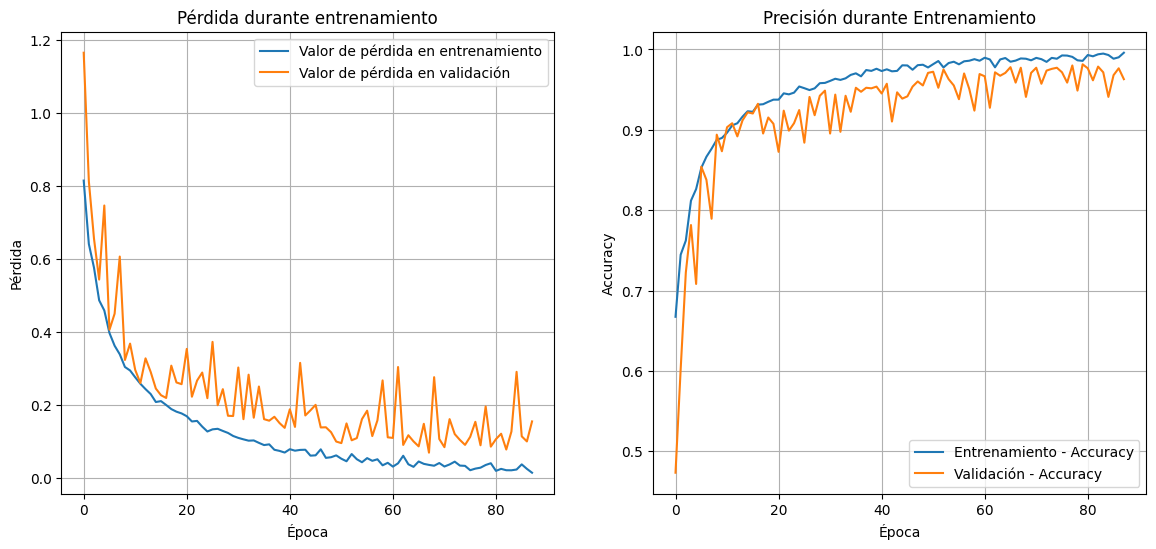

In [16]:
# Parámetros
num_epochs = 150
patience = 20

# Métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_1.state_dict())
epochs_without_improvement = 0

# Bucle de entrenamiento
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_1, train_data_load, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_1, val_data_load, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
          f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model_1.state_dict())
        epochs_without_improvement = 0
        torch.save(model_1.state_dict(), 'best_model_arq_1.pth')
        print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
    else:
        epochs_without_improvement += 1

    # Configuración parada temprana, se detiene si no mejora despues de 20 épocas
    if epochs_without_improvement >= patience:
        print(f"Parada temprana en la época {epoch+1}")
        break

# Cargar el mejor modelo al final
model_1.load_state_dict(best_model_wts)

# Gráficas
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Valor de pérdida en entrenamiento')
plt.plot(val_losses, label='Valor de pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Entrenamiento - Accuracy')
plt.plot(val_accuracies, label='Validación - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Precisión durante Entrenamiento')
plt.legend()
plt.grid(True)

plt.show()

In [13]:
# Cargar mejor modelo para sacar metricas
model_1 = TumorMRICNN(num_classes=4).to(device)
model_1.load_state_dict(torch.load('best_model_arq_1.pth'))
model_1.eval()

TumorMRICNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

### Reporte de clasificación arquitectura 1

In [14]:
# Obtener todas las predicciones y etiquetas verdaderas
y_true_1 = []
y_pred_1 = []

model_1.eval()
with torch.no_grad():
    for images, labels in val_data_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, preds = torch.max(outputs, 1)
        y_true_1.extend(labels.cpu().numpy())
        y_pred_1.extend(preds.cpu().numpy())

# Reporte detallado
print(classification_report(y_true_1, y_pred_1, target_names=val_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       324
     healthy       0.99      0.98      0.98       400
  meningioma       0.95      0.97      0.96       329
   pituitary       0.98      0.99      0.98       352

    accuracy                           0.98      1405
   macro avg       0.98      0.98      0.98      1405
weighted avg       0.98      0.98      0.98      1405



### Matriz de confusión arquitecturta 1

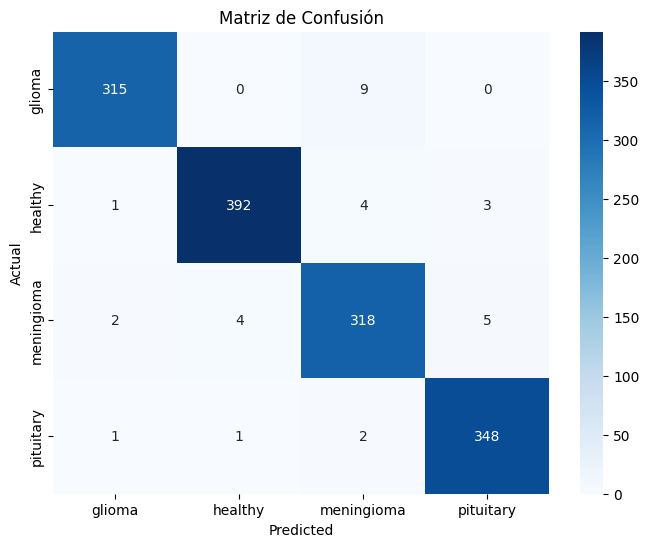

In [15]:
# Matriz de confusión
cm = confusion_matrix(y_true_1, y_pred_1)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### Probando arquitectura 1 con algunas imágenes

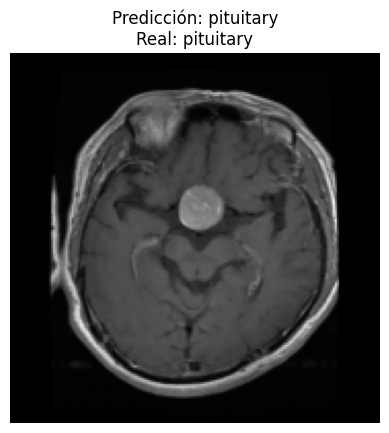

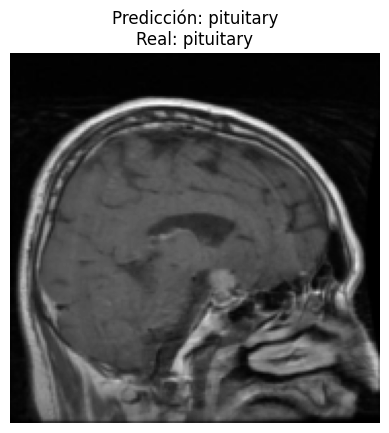

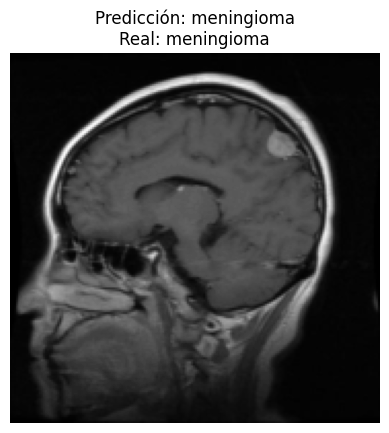

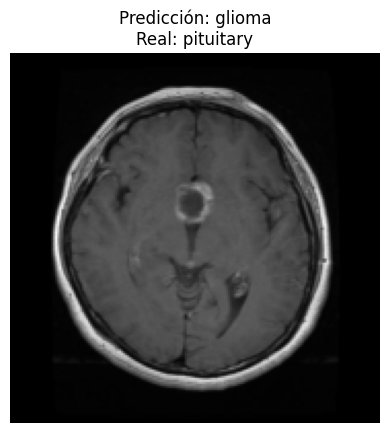

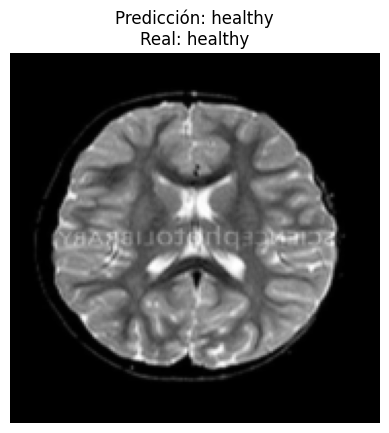

In [20]:
# Tomar imágenes aleatorias del val_dataset
indices = random.sample(range(len(val_db)), 5)  # 5 imágenes al azar
model_1.eval()

for idx in indices:
    image, label = val_db[idx]
    image = image.unsqueeze(0).to(device)  # Agregar dimensión batch

    output = model_1(image)
    _, pred = torch.max(output, 1)

    plt.imshow(image.cpu().squeeze(0).permute(1,2,0), cmap='gray')
    plt.title(f'Predicción: {val_dataset.classes[pred.item()]}\nReal: {val_dataset.classes[label]}')
    plt.axis('off')
    plt.show()

### Arquitectura # 2 Red Neuronal Convolicional (CNN) 

Cada bloque contiene:

* Dos capas Conv2D con kernel 3x3 y padding=1.
* Batch Normalization después de cada convolución.
* Activación ReLU.
* MaxPooling2D (2x2) para reducir el tamaño espacial.
* Dropout para evitar sobreajuste (25%).

La cantidad de filtros en los bloques es:

* 1° bloque: 64 filtros
* 2° bloque: 32 filtros
* 3° bloque: 16 filtros
* 4° bloque: 8 filtros

Capas Finales

* Flatten del tensor
* Capa densa de 968 unidades a 1024 unidades, con Dropout (50%).
* Capa de salida de 1024 a 4 unidades (una por clase).

In [16]:
class MultiClassifier1(nn.Module):
    def __init__(self):
        super(MultiClassifier1, self).__init__()
        
        #-------------------- Primer bloque convolucional --------------------------
        # Capa convolicional 1 con entrada (1 canal) , con 64 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64) # Normalización por lotes

        # Capa convolicional 2 con 64 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Normalización por lotes

        # Max Pooling para Reducción de tamaño espacial 
        self.maxpool1 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout1 = nn.Dropout(0.25)
        
        #-------------------- Segundo bloque convolucional --------------------------
        # Capa convolicional 3 con 32 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Capa convolicional 4 con 32 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        # Max Pooling para Reducción de tamaño espacial 
        self.maxpool2 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout2 = nn.Dropout(0.25)

        #-------------------- Tercer bloque convolucional --------------------------
        # Capa convolicional 5 con 16 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(16)

        # Capa convolicional 6 con 16 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(16)

        # Max Pooling para Reducción de tamaño espacial 
        self.maxpool3 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout3 = nn.Dropout(0.25)
        
        #-------------------- Cuarto bloque convolucional --------------------------
        # Capa convolicional 7 con 8 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv7 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(8)

        # Capa convolicional 8 con 8 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv8 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(8)

        # Max Pooling para Reducción de tamaño espacial 
        self.maxpool4 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout4 = nn.Dropout(0.25)

        # Capa de flatten para convertir el tensor en vector
        self.flatten = nn.Flatten()

        # Capa densa 1 completamente conectada
        self.fc1 = nn.Linear(8 * 11 * 11, 1024)  # 8x11x11 debido a la reducción de tamaño en las capas previas
        self.dropout5 = nn.Dropout(0.5)

        # Capa de salida
        self.fc2 = nn.Linear(1024, 4)  # 4 clases para la clasificación

    def forward(self, x):
        # se pasan las imágenes a través de las capas convolucionales
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.maxpool4(x)
        x = self.dropout4(x)

        # Aplanamos la salida para las capas totalmente conectadas
        x = self.flatten(x)

        # Capa densa 1
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)

        # Capa de salida (para clasificación)
        x = self.fc2(x)

        return x

### Definicion de optimizador y funcion de perdida
se implementa el optimizador Adam con una tasa de aprendizaje del 0.001 y funcion de perdida CrossEntropyLoss

In [17]:
# instancia del modelo
model_2 = MultiClassifier1().to(device)

# funcion de perdida
criterion = nn.CrossEntropyLoss()

# optimizador
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

print(model_2)

MultiClassifier1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), strid

In [35]:
summary(model_2, input_size=(1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 180]             640
       BatchNorm2d-2         [-1, 64, 180, 180]             128
            Conv2d-3         [-1, 64, 180, 180]          36,928
       BatchNorm2d-4         [-1, 64, 180, 180]             128
         MaxPool2d-5           [-1, 64, 90, 90]               0
           Dropout-6           [-1, 64, 90, 90]               0
            Conv2d-7           [-1, 32, 90, 90]          18,464
       BatchNorm2d-8           [-1, 32, 90, 90]              64
            Conv2d-9           [-1, 32, 90, 90]           9,248
      BatchNorm2d-10           [-1, 32, 90, 90]              64
        MaxPool2d-11           [-1, 32, 45, 45]               0
          Dropout-12           [-1, 32, 45, 45]               0
           Conv2d-13           [-1, 16, 45, 45]           4,624
      BatchNorm2d-14           [-1, 16,

### Entrenamiento y evaluación del modelo

Se aplican las funciones de entrenamiento y evaluación en un bucle durante 150 épocas con una parada temprana de 20, observando el progreso del modelo en cada una de ellas.

Epoch [1/150] | Train Loss: 0.9231 | Train Acc: 0.6125 | Val Loss: 0.6037 | Val Acc: 0.7673
Mejor modelo guardado en la época 1 con pérdida de validación 0.6037
Epoch [2/150] | Train Loss: 0.6420 | Train Acc: 0.7339 | Val Loss: 0.5023 | Val Acc: 0.7815
Mejor modelo guardado en la época 2 con pérdida de validación 0.5023
Epoch [3/150] | Train Loss: 0.5782 | Train Acc: 0.7620 | Val Loss: 0.4781 | Val Acc: 0.8071
Mejor modelo guardado en la época 3 con pérdida de validación 0.4781
Epoch [4/150] | Train Loss: 0.5296 | Train Acc: 0.7866 | Val Loss: 0.5828 | Val Acc: 0.7359
Epoch [5/150] | Train Loss: 0.4969 | Train Acc: 0.7946 | Val Loss: 0.4755 | Val Acc: 0.8285
Mejor modelo guardado en la época 5 con pérdida de validación 0.4755
Epoch [6/150] | Train Loss: 0.4425 | Train Acc: 0.8192 | Val Loss: 0.3566 | Val Acc: 0.8534
Mejor modelo guardado en la época 6 con pérdida de validación 0.3566
Epoch [7/150] | Train Loss: 0.4137 | Train Acc: 0.8373 | Val Loss: 0.3098 | Val Acc: 0.8918
Mejor model

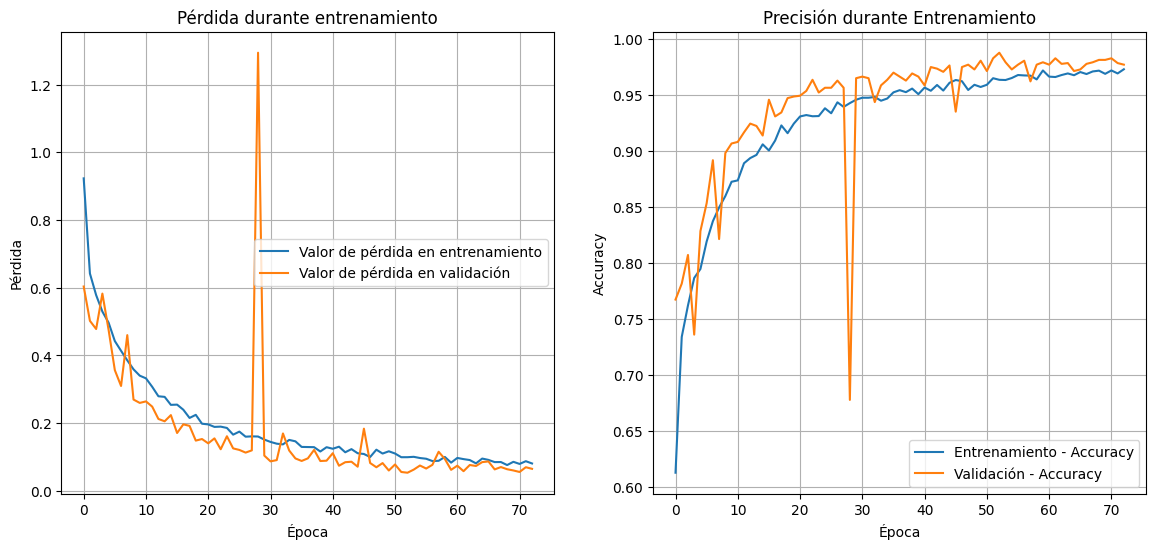

In [36]:
# Parámetros
num_epochs = 150
patience = 20

# Métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_2.state_dict())
epochs_without_improvement = 0

# Bucle de entrenamiento
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_2, train_data_load, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_2, val_data_load, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
          f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model_2.state_dict())
        epochs_without_improvement = 0
        torch.save(model_2.state_dict(), 'best_model_arq_2.pth')
        print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
    else:
        epochs_without_improvement += 1

    # Configuración parada temprana, se detiene si no mejora despues de 20 épocas
    if epochs_without_improvement >= patience:
        print(f"Parada temprana en la época {epoch+1}")
        break

# Cargar el mejor modelo al final
model_2.load_state_dict(best_model_wts)

# Gráficas
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Valor de pérdida en entrenamiento')
plt.plot(val_losses, label='Valor de pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Entrenamiento - Accuracy')
plt.plot(val_accuracies, label='Validación - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Precisión durante Entrenamiento')
plt.legend()
plt.grid(True)

plt.show()

In [19]:
# Cargar mejor modelo para sacar metricas
model_2 = MultiClassifier1().to(device)
model_2.load_state_dict(torch.load('best_model_arq_2.pth'))
model_2.eval()

MultiClassifier1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), strid

In [38]:
summary(model_2, input_size=(1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 180]             640
       BatchNorm2d-2         [-1, 64, 180, 180]             128
            Conv2d-3         [-1, 64, 180, 180]          36,928
       BatchNorm2d-4         [-1, 64, 180, 180]             128
         MaxPool2d-5           [-1, 64, 90, 90]               0
           Dropout-6           [-1, 64, 90, 90]               0
            Conv2d-7           [-1, 32, 90, 90]          18,464
       BatchNorm2d-8           [-1, 32, 90, 90]              64
            Conv2d-9           [-1, 32, 90, 90]           9,248
      BatchNorm2d-10           [-1, 32, 90, 90]              64
        MaxPool2d-11           [-1, 32, 45, 45]               0
          Dropout-12           [-1, 32, 45, 45]               0
           Conv2d-13           [-1, 16, 45, 45]           4,624
      BatchNorm2d-14           [-1, 16,

### Reporte de clasificación arquitectura 2

In [20]:
# Obtener todas las predicciones y etiquetas verdaderas
y_true_2 = []
y_pred_2 = []

model_2.eval()
with torch.no_grad():
    for images, labels in val_data_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, preds = torch.max(outputs, 1)
        y_true_2.extend(labels.cpu().numpy())
        y_pred_2.extend(preds.cpu().numpy())

# Reporte detallado
print(classification_report(y_true_2, y_pred_2, target_names=val_dataset.classes))

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       324
     healthy       0.99      0.99      0.99       400
  meningioma       0.97      0.99      0.98       329
   pituitary       0.99      0.99      0.99       352

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405



### Matriz de confisión arquitectura 2

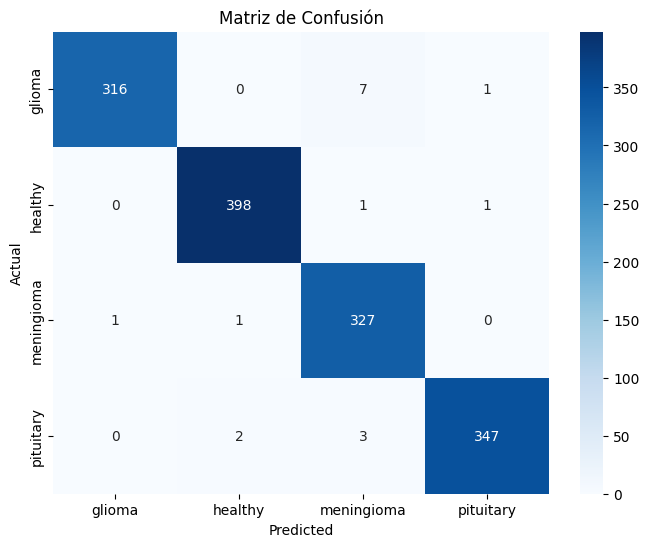

In [21]:
# Matriz de confusión
cm = confusion_matrix(y_true_2, y_pred_2)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### Probando arquitectura 2 con algunas imágenes

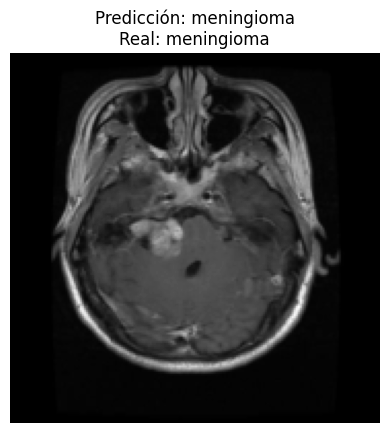

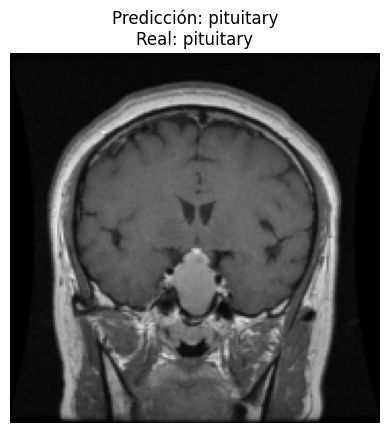

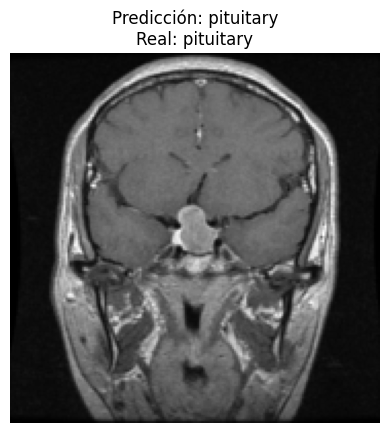

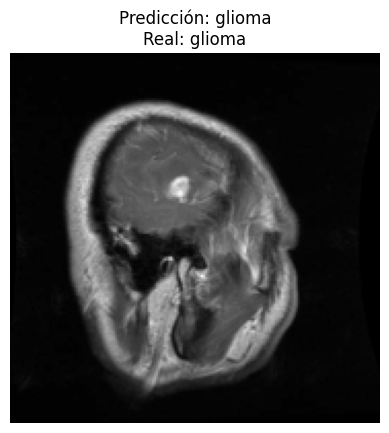

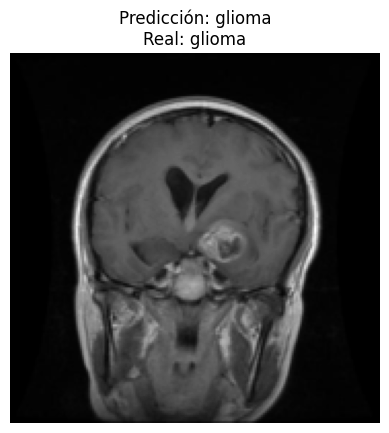

In [41]:
# Tomar imágenes aleatorias del val_dataset
indices = random.sample(range(len(val_db)), 5)  # 5 imágenes al azar
model_2.eval()

for idx in indices:
    image, label = val_db[idx]
    image = image.unsqueeze(0).to(device)  # Agregar dimensión batch

    output = model_2(image)
    _, pred = torch.max(output, 1)

    plt.imshow(image.cpu().squeeze(0).permute(1,2,0), cmap='gray')
    plt.title(f'Predicción: {val_dataset.classes[pred.item()]}\nReal: {val_dataset.classes[label]}')
    plt.axis('off')
    plt.show()

### Arquitectura # 3 Red Neuronal Convolicional (CNN)  - EfficientNetB0

Esta CNN cuenta con tres "Grandes" bloques:

Bloque 1: Busca extraer características simples (Bordes, contornos y patrones simples):


* Capa 1 Conv2d: 32 filtros, kernel 3x3 y padding=1.
* Batch Normalization después de cada convolución.
* Maxpool: 2x2, reduce resolución a la mitad


Bloque 2: Este bloque en relidad cuenta con 16 bloques de MBConv (Mobile Inverted Bottleneck Convolution), busca extraer características como texturas y formas más complejas:

| Etapa | Tipo de bloque | # Bloques | Filtros (in → out) | Kernel |
|-------|----------------|-----------|---------------------|--------|
| MBConv1 | 1 bloque     | 1         | 32 → 16             | 3×3    |
| MBConv6 | 2 bloques    | 2         | 16 → 24             | 3×3    |
| MBConv6 | 2 bloques    | 2         | 24 → 40             | 5×5    |
| MBConv6 | 3 bloques    | 3         | 40 → 80             | 3×3    |
| MBConv6 | 3 bloques    | 3         | 80 → 112            | 5×5    |
| MBConv6 | 4 bloques    | 4         | 112 → 192           | 5×5    |
| MBConv6 | 1 bloque     | 1         | 192 → 320           | 3×3    |


Bloque 3: Bloque de clasificación (4 clases):

* Capa 1 Conv2d: 1280 filtros, kernel 1x1 y padding=1.
* AdaptiveAvgPool2d(1×1)
* Dropout(p=0.2)
* Capa densa: Predicción de clases (linear).

### Preprocesado: 

Dada la literatura, esta red es recomendable con un tamaño de imágen de 224x224, con tres canales y una normalización propia.

In [37]:
# Tamaño de las imágenes
img_size = 224

# Tamaño de batch
batch_size = 16

# Porcentaje de datos para validación
val_split = 0.2

# Semilla
seed = 42
torch.manual_seed(seed)

###  Pipeline de preprocesamiento

A continuacion se se crea el pipeline de preprocesamiento de images, el cual realiza los siguientes pasos:
* redimensiona la imagen a 224x224
* se aplica normalizacion propia para esta red
------
Para el conjunto de datos de entrenamiento, se decide aplicar, además de los pasos previos, técnicas de aumento de datos (data augmentation) para enriquecer la variedad de ejemplos y mejorar la generalización del modelo.
* se  refleja la imagen de izquierda a derecha.
* se rota la imagen de manera aleatoria entre -15 y 15 grados.
* se ajusta aleatoriamente el brillo y el contraste de la imagen dentro de un rango de 0.2

In [38]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # Normalización estándar ImageNet
    transforms.Normalize([0.485, 0.456, 0.406],  
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Division del dataset

El dataset se divide en datos de train y val. Adicional, se aplica el pipeline de preprocesado.

In [39]:
# Cargar el dataset con ImageFolder dado que la estructura provienen de directorios 

dataset = datasets.ImageFolder(root=dataset_path)

# Obtener las etiquetas de las imágenes
labels = [item[1] for item in dataset.samples]  

# Dividimos el dataset de manera estratificada
Stratified = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=seed)

for train_index, val_index in Stratified.split(np.zeros(len(labels)), labels):
    pass  # Solo necesitamos una división

# Con transform aplicar el pipeline de preprocesado espeficado en la celda anterior para cada dataset
train_dataset = ImageFolder(root=dataset_path, transform=train_transform)
val_dataset = ImageFolder(root=dataset_path, transform=val_transform)

# Seleccionamos los indices adecuado de cada dataset transformado
train_db = torch.utils.data.Subset(train_dataset, train_index)
val_db = torch.utils.data.Subset(val_dataset, val_index)

# Cargamos los datos por baches
train_data_load = DataLoader(train_db, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data_load = DataLoader(val_db, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

###  Intanciar el modelo y configurar el proceso de transfer learning

In [25]:
model_3 = models.efficientnet_b0(pretrained=True)

# Descongelar capas para realizar el proceso de Fine-tuning con los datos propios
for param in model_3.features.parameters():
    param.requires_grad = True

# Reemplazar la última capa para clasificación en 4 clases
num_features = model_3.classifier[1].in_features
model_3.classifier[1] = nn.Linear(num_features, 4)  # 4 clases: glioma, meningioma, pituitary, healthy

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 409MB/s]


### Definicion de optimizador y funcion de perdida
se implementa el optimizador Adam con una tasa de aprendizaje del 0.001 y funcion de perdida CrossEntropyLoss

In [26]:
model_3 = model_3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [15]:
summary(model_3, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

### Entrenamiento y evaluación del modelo

Se aplican las funciones de entrenamiento y evaluación en un bucle durante 150 épocas con una parada temprana de 20, observando el progreso del modelo en cada una de ellas.

Epoch [1/150] | Train Loss: 0.2763 | Train Acc: 0.8994 | Val Loss: 0.1152 | Val Acc: 0.9637
Mejor modelo guardado en la época 1 con pérdida de validación 0.1152
Epoch [2/150] | Train Loss: 0.1304 | Train Acc: 0.9567 | Val Loss: 0.2025 | Val Acc: 0.9146
Epoch [3/150] | Train Loss: 0.1116 | Train Acc: 0.9624 | Val Loss: 0.0609 | Val Acc: 0.9808
Mejor modelo guardado en la época 3 con pérdida de validación 0.0609
Epoch [4/150] | Train Loss: 0.0790 | Train Acc: 0.9770 | Val Loss: 0.0995 | Val Acc: 0.9701
Epoch [5/150] | Train Loss: 0.0627 | Train Acc: 0.9795 | Val Loss: 0.0417 | Val Acc: 0.9872
Mejor modelo guardado en la época 5 con pérdida de validación 0.0417
Epoch [6/150] | Train Loss: 0.0745 | Train Acc: 0.9778 | Val Loss: 0.0397 | Val Acc: 0.9872
Mejor modelo guardado en la época 6 con pérdida de validación 0.0397
Epoch [7/150] | Train Loss: 0.0389 | Train Acc: 0.9875 | Val Loss: 0.0723 | Val Acc: 0.9758
Epoch [8/150] | Train Loss: 0.0598 | Train Acc: 0.9815 | Val Loss: 0.1113 | Val 

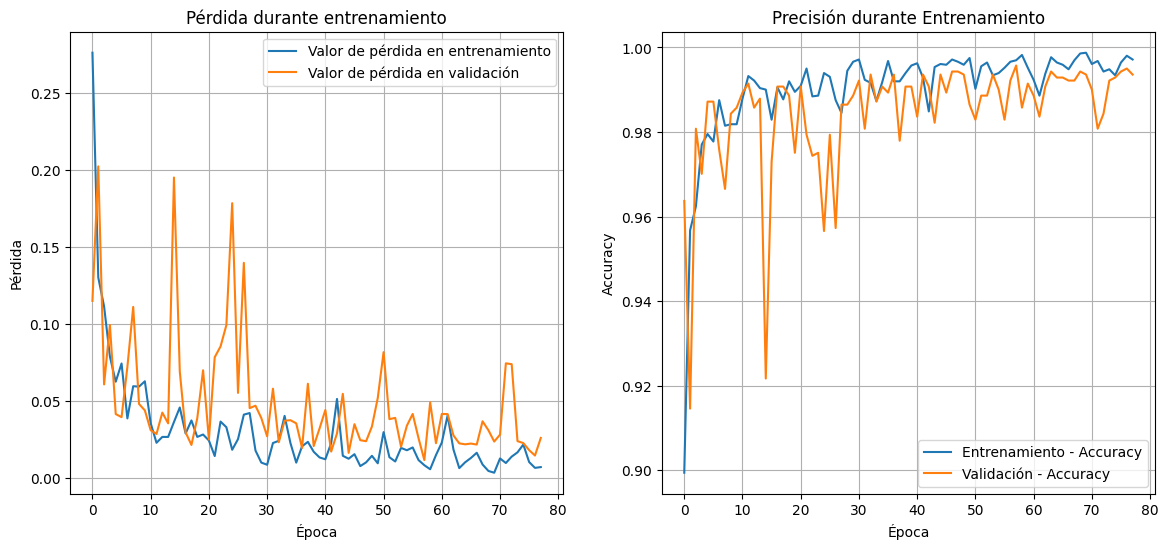

In [19]:
# Parámetros
num_epochs = 150
patience = 20

# Métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_3.state_dict())
epochs_without_improvement = 0

# Bucle de entrenamiento
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_3, train_data_load, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_3, val_data_load, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
          f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model_3.state_dict())
        epochs_without_improvement = 0
        torch.save(model_3.state_dict(), 'best_model_effi_t.pth')
        print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Parada temprana en la época {epoch+1}")
        break

# Cargar el mejor modelo al final
model_3.load_state_dict(best_model_wts)

# Gráficas
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Valor de pérdida en entrenamiento')
plt.plot(val_losses, label='Valor de pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Entrenamiento - Accuracy')
plt.plot(val_accuracies, label='Validación - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Precisión durante Entrenamiento')
plt.legend()
plt.grid(True)

plt.show()

In [51]:
# Cargar los pesos del mejor modelo entrenado
model_3.load_state_dict(torch.load('best_model_effi_t.pth', map_location=device))

# Enviar a dispositivo y poner en modo evaluación
model_3 = model_3.to(device)
model_3.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Reporte de clasificación arquitectura 3: EfficientNetB0 

In [52]:
# Obtener todas las predicciones y etiquetas verdaderas
y_true_3 = []
y_pred_3 = []

with torch.no_grad():
    for images, labels in val_data_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, preds = torch.max(outputs, 1)
        y_true_3.extend(labels.cpu().numpy())
        y_pred_3.extend(preds.cpu().numpy())

# Reporte detallado
print(classification_report(y_true_3, y_pred_3, target_names=val_dataset.classes))

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       324
     healthy       1.00      1.00      1.00       400
  meningioma       0.99      1.00      0.99       329
   pituitary       0.99      0.99      0.99       352

    accuracy                           1.00      1405
   macro avg       0.99      1.00      0.99      1405
weighted avg       1.00      1.00      1.00      1405



### Matriz de confusión arquitectura 3: EfficientNetB0 

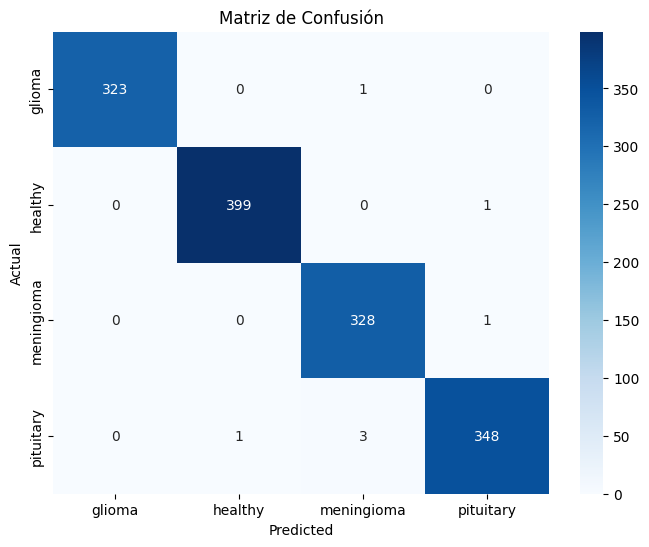

In [53]:
# Matriz de confusión
cm = confusion_matrix(y_true_3, y_pred_3)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

### Probando algunas imágenes arquitectura 3: EfficientNetB0 

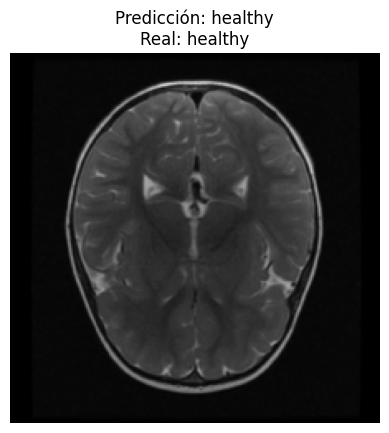

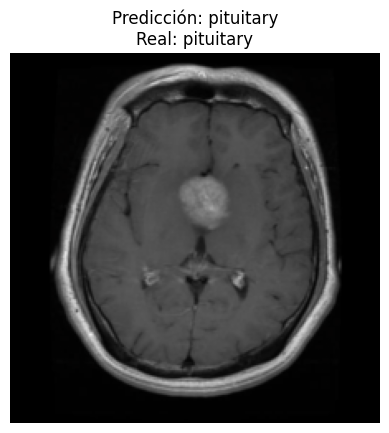

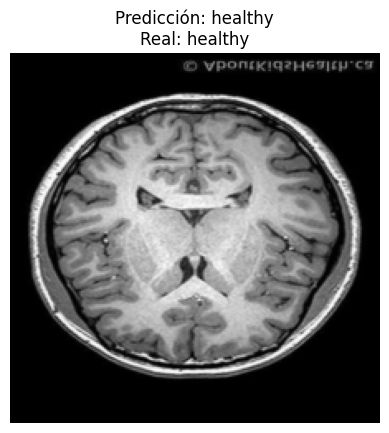

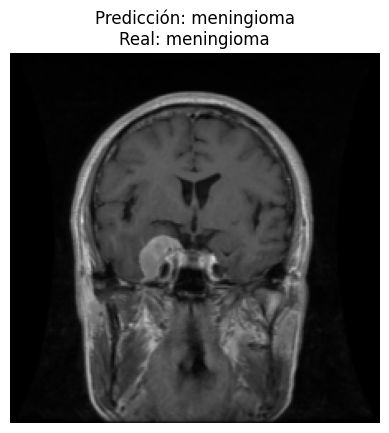

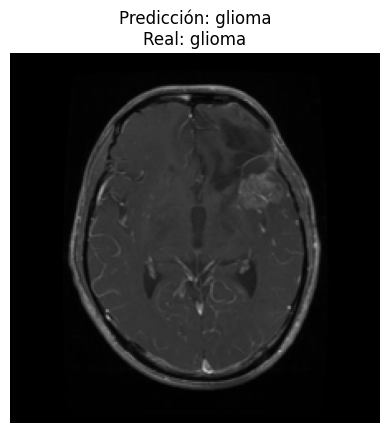

In [60]:
# Para desnormalizar
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

indices = random.sample(range(len(val_db)), 5)

for idx in indices:
    image, label = val_db[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_3(input_tensor)
        _, pred = torch.max(output, 1)

    # Desnormalizar y convertir a numpy para visualizar
    img_show = denormalize(image).cpu().permute(1, 2, 0).numpy()
    img_show = img_show.clip(0, 1)  # Asegura que esté en rango [0,1]

    # Mostrar imagen
    plt.imshow(img_show)
    plt.title(f'Predicción: {val_dataset.classes[pred.item()]}\nReal: {val_dataset.classes[label]}')
    plt.axis('off')
    plt.show()

### 8. Comparacion de modelos

In [55]:
def metricas_evalucion(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_true, y_pred, average='macro'),
        "F1 Score (macro)": f1_score(y_true, y_pred, average='macro'),
        "F1 Score (weighted)": f1_score(y_true, y_pred, average='weighted')
    }

# Evaluar cada modelo
metricas_1 = metricas_evalucion(y_true_1, y_pred_1)
metricas_2 = metricas_evalucion(y_true_2, y_pred_2)
metricas_3 = metricas_evalucion(y_true_3, y_pred_3)

# Crear DataFrame con las métricas
final_df = pd.DataFrame([metricas_1, metricas_2, metricas_3],index=['TumorMRICNN', 'CNN + Dropout', 'EfficientNetB0'])

print("\nComparación de Métricas de Evaluación:")
display(final_df.round(4))


Comparación de Métricas de Evaluación:


,Accuracy,Precision (macro),Recall (macro),F1 Score (macro),F1 Score (weighted)
TumorMRICNN,0.9772,0.9768,0.9769,0.9768,0.9773
CNN + Dropout,0.9879,0.9878,0.9875,0.9876,0.9879
EfficientNetB0,0.9950,0.9949,0.9950,0.9950,0.9950


In [44]:
def evaluate_model_detailed(y_true, y_pred, class_names=None):
    # Métricas globales
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_true, y_pred, average='macro'),
        "F1 Score (macro)": f1_score(y_true, y_pred, average='macro'),
        "F1 Score (weighted)": f1_score(y_true, y_pred, average='weighted')
    }

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    # Métricas por clase
    detailed_metrics = []
    for i in range(num_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        detailed_metrics.append({
            "Class": class_names[i],
            "TP": TP, "FP": FP, "FN": FN, "TN": TN,
            "Recall": recall,
            "Precision": precision,
            "F1 Score": f1
        })

    return metrics, pd.DataFrame(detailed_metrics)


class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Obtener métricas por clase para cada modelo
_, class_metrics_1 = evaluate_model_detailed(y_true_1, y_pred_1, class_names)
_, class_metrics_2 = evaluate_model_detailed(y_true_2, y_pred_2, class_names)
_, class_metrics_3 = evaluate_model_detailed(y_true_3, y_pred_3, class_names)

# Etiquetar modelo en cada DataFrame
class_metrics_1['Modelo'] = 'TumorMRICNN'
class_metrics_2['Modelo'] = 'CNN + Dropout'
class_metrics_3['Modelo'] = 'EfficientNetB0'

# Combinar en un solo DataFrame
all_class_metrics = pd.concat([class_metrics_1, class_metrics_2, class_metrics_3])

# Mostrar tabla
from IPython.display import display
display(all_class_metrics.round(4))

,Class,TP,FP,FN,TN,Recall,Precision,F1 Score,Modelo
0,glioma,315,4,9,1077,0.9722,0.9875,0.9798,TumorMRICNN
1,healthy,392,5,8,1000,0.9800,0.9874,0.9837,TumorMRICNN
2,meningioma,318,15,11,1061,0.9666,0.9550,0.9607,TumorMRICNN
3,pituitary,348,8,4,1045,0.9886,0.9775,0.9831,TumorMRICNN
0,glioma,316,1,8,1080,0.9753,0.9968,0.9860,CNN + Dropout
1,healthy,398,3,2,1002,0.9950,0.9925,0.9938,CNN + Dropout
2,meningioma,327,11,2,1065,0.9939,0.9675,0.9805,CNN + Dropout
3,pituitary,347,2,5,1051,0.9858,0.9943,0.9900,CNN + Dropout
0,glioma,323,0,1,1081,0.9969,1.0000,0.9985,EfficientNetB0
1,healthy,400,2,0,1003,1.0000,0.9950,0.9975,EfficientNetB0


### 9. Pruebas de ablación sobre modelo seleccionado (efficientnet_b0)

param.requires_grad = False, permite congelar las pesos de las capas convolucionales, es decir, mantiene los parámetros preentrenados

In [32]:
model_4 = models.efficientnet_b0(pretrained=True)

# Descongelar capas para realizar el proceso de Fine-tuning con los datos propios
for param in model_4.features.parameters():
    param.requires_grad = False

# Reemplazar la última capa para clasificación en 4 clases
num_features = model_4.classifier[1].in_features
model_4.classifier[1] = nn.Linear(num_features, 4)  # 4 clases: glioma, meningioma, pituitary, healthy

In [34]:
model_4 = model_4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

Epoch [1/150] | Train Loss: 0.6183 | Train Acc: 0.7852 | Val Loss: 0.4540 | Val Acc: 0.8562
Mejor modelo guardado en la época 1 con pérdida de validación 0.4540
Epoch [2/150] | Train Loss: 0.4430 | Train Acc: 0.8355 | Val Loss: 0.3796 | Val Acc: 0.8641
Mejor modelo guardado en la época 2 con pérdida de validación 0.3796
Epoch [3/150] | Train Loss: 0.4147 | Train Acc: 0.8556 | Val Loss: 0.3360 | Val Acc: 0.8854
Mejor modelo guardado en la época 3 con pérdida de validación 0.3360
Epoch [4/150] | Train Loss: 0.3833 | Train Acc: 0.8612 | Val Loss: 0.3365 | Val Acc: 0.8847
Epoch [5/150] | Train Loss: 0.3779 | Train Acc: 0.8629 | Val Loss: 0.3245 | Val Acc: 0.8840
Mejor modelo guardado en la época 5 con pérdida de validación 0.3245
Epoch [6/150] | Train Loss: 0.3807 | Train Acc: 0.8560 | Val Loss: 0.2961 | Val Acc: 0.9025
Mejor modelo guardado en la época 6 con pérdida de validación 0.2961
Epoch [7/150] | Train Loss: 0.3576 | Train Acc: 0.8701 | Val Loss: 0.3401 | Val Acc: 0.8776
Epoch [8/15

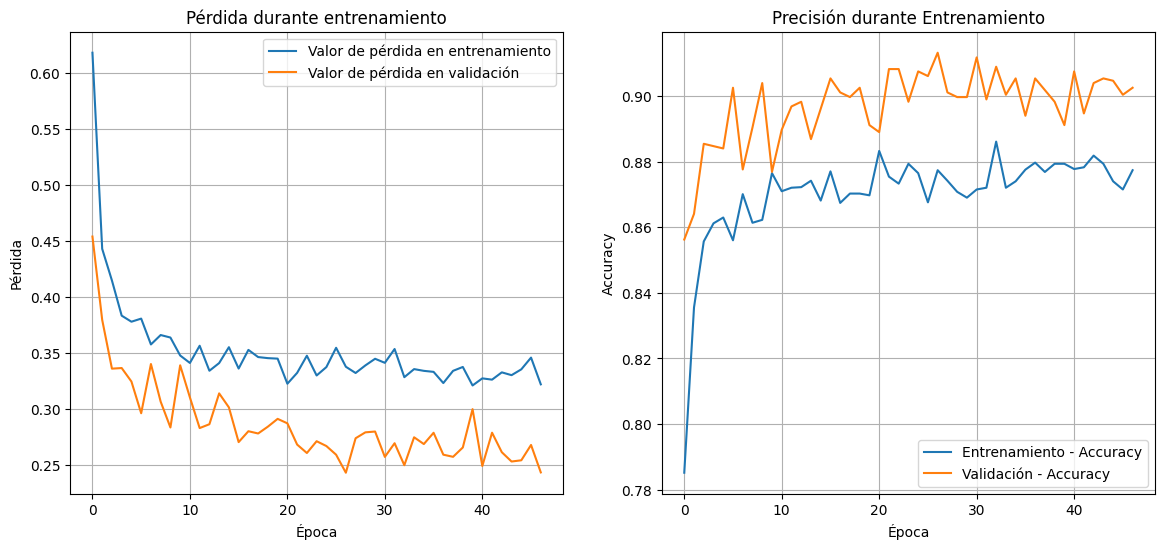

In [40]:
# Parámetros
num_epochs = 150
patience = 20

# Métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_4.state_dict())
epochs_without_improvement = 0

# Bucle de entrenamiento
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_4, train_data_load, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_4, val_data_load, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
          f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Guardar mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model_4.state_dict())
        epochs_without_improvement = 0
        torch.save(model_4.state_dict(), 'best_model_effi.pth')
        print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Parada temprana en la época {epoch+1}")
        break

# Cargar el mejor modelo al final
model_4.load_state_dict(best_model_wts)

# Gráficas
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Valor de pérdida en entrenamiento')
plt.plot(val_losses, label='Valor de pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Entrenamiento - Accuracy')
plt.plot(val_accuracies, label='Validación - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Precisión durante Entrenamiento')
plt.legend()
plt.grid(True)

plt.show()

In [57]:
# Cargar los pesos del mejor modelo entrenado
model_4.load_state_dict(torch.load('best_model_effi.pth', map_location=device))

# Enviar a dispositivo y poner en modo evaluación
model_4 = model_4.to(device)
model_4.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [58]:
# Obtener todas las predicciones y etiquetas verdaderas
y_true_4 = []
y_pred_4 = []

with torch.no_grad():
    for images, labels in val_data_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model_4(images)
        _, preds = torch.max(outputs, 1)
        y_true_4.extend(labels.cpu().numpy())
        y_pred_4.extend(preds.cpu().numpy())

# Reporte detallado
print(classification_report(y_true_4, y_pred_4, target_names=val_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.98      0.86      0.91       324
     healthy       0.93      0.97      0.95       400
  meningioma       0.80      0.87      0.84       329
   pituitary       0.95      0.94      0.94       352

    accuracy                           0.91      1405
   macro avg       0.92      0.91      0.91      1405
weighted avg       0.92      0.91      0.91      1405



In [ ]:
def metricas_evalucion(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_true, y_pred, average='macro'),
        "F1 Score (macro)": f1_score(y_true, y_pred, average='macro'),
        "F1 Score (weighted)": f1_score(y_true, y_pred, average='weighted')
    }

# Evaluar cada modelo
metricas_1 = metricas_evalucion(y_true_3, y_pred_3)
metricas_2 = metricas_evalucion(y_true_4, y_pred_4)


# Crear DataFrame con las métricas
final_df = pd.DataFrame([metricas_1, metricas_2],index=['EfficientNetB0 + Trns. L.', 'EfficientNetB0'])

print("\nComparación de Métricas de Evaluación:")
display(final_df.round(4))


Comparación de Métricas de Evaluación:


,Accuracy,Precision (macro),Recall (macro),F1 Score (macro),F1 Score (weighted)
EfficientNetB0 + Trns. L.,0.9950,0.9949,0.9950,0.9950,0.9950
EfficientNetB0,0.9132,0.9156,0.9095,0.9112,0.9138
